# NETWORK SCIENCE PROJECT

## Predicting music artist collaborations using network graphs

Team members: Karl Jaagup Kask, Ludvig Leis, Kristjan Ševerev 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

!pip install python-igraph==0.8.3
!apt install libcairo2-dev pkg-config python3-dev
!pip install python-igraph leidenalg cairocffi

import igraph as ig
from networkx.algorithms import community

import re

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1).
python3-dev is already the newest version (3.6.7-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


### Looking at the data 

In [2]:
edge_list = pd.read_csv("real_edges_small.csv" )
nodes = pd.read_csv("real_nodes_small.csv")

In [5]:
edge_list

,name,artist_to,popularity
0,Justin Bieber,ZAYN,100
1,Justin Bieber,Shawn Mendes,100
2,Justin Bieber,Camila Cabello,100
3,Justin Bieber,Niall Horan,100
4,Justin Bieber,Selena Gomez,100
...,...,...,...
33362,Dustin Lynch,Chase Rice,71
33363,Dustin Lynch,Frankie Ballard,71
33364,Dustin Lynch,Eric Paslay,71
33365,Dustin Lynch,Hunter Hayes,71


In [4]:
edge_list['name'].value_counts()

Eve                       60
Plan B                    60
Teto                      40
UZI                       40
Zion                      40
                          ..
Casper Magico             20
Die drei ??? Kids         17
Okieriete Onaodowan       14
SUGA                      12
Thirty Seconds To Mars     9
Name: name, Length: 1660, dtype: int64

In [5]:
edge_list['artist_to'].value_counts()

Julia Michaels                   42
Fifth Harmony                    39
Cauty                            37
Alessia Cara                     36
Nio Garcia                       35
                                 ..
Jason Boland & The Stragglers     1
David Penn                        1
The Click                         1
Ministry                          1
Sing Street                       1
Name: artist_to, Length: 10759, dtype: int64

Removing nodes that cause error in the graph creation

In [6]:
filter = edge_list["name"]=="Joey Bada$$"
indexNames = edge_list.loc[filter].index
print(len(edge_list))
edge_list.drop(indexNames , inplace=True)
print(len(edge_list))
print(edge_list.loc[filter])

33367
33347
Empty DataFrame
Columns: [name, artist_to, popularity]
Index: []


In [7]:
filter = edge_list["artist_to"]=="Joey Bada$$"
indexNames = edge_list.loc[filter].index
print(len(edge_list))
edge_list.drop(indexNames , inplace=True)
print(len(edge_list))
print(edge_list.loc[filter])

33347
33332
Empty DataFrame
Columns: [name, artist_to, popularity]
Index: []


In [8]:
nodes

,name
0,Disme
1,Celtic Woman
2,Electronic
3,Nathaniel Rateliff
4,New Found Glory
...,...
11003,Bruce Dickinson
11004,Bausa
11005,Chris Wandell
11006,Kati & Azuro


### Creating the graph

In [9]:
G=nx.from_pandas_edgelist(edge_list[:100], source='name', target='artist_to', create_using=nx.Graph())

In [12]:
G=nx.from_pandas_edgelist(edge_list, source='name', target='artist_to', create_using=nx.Graph())

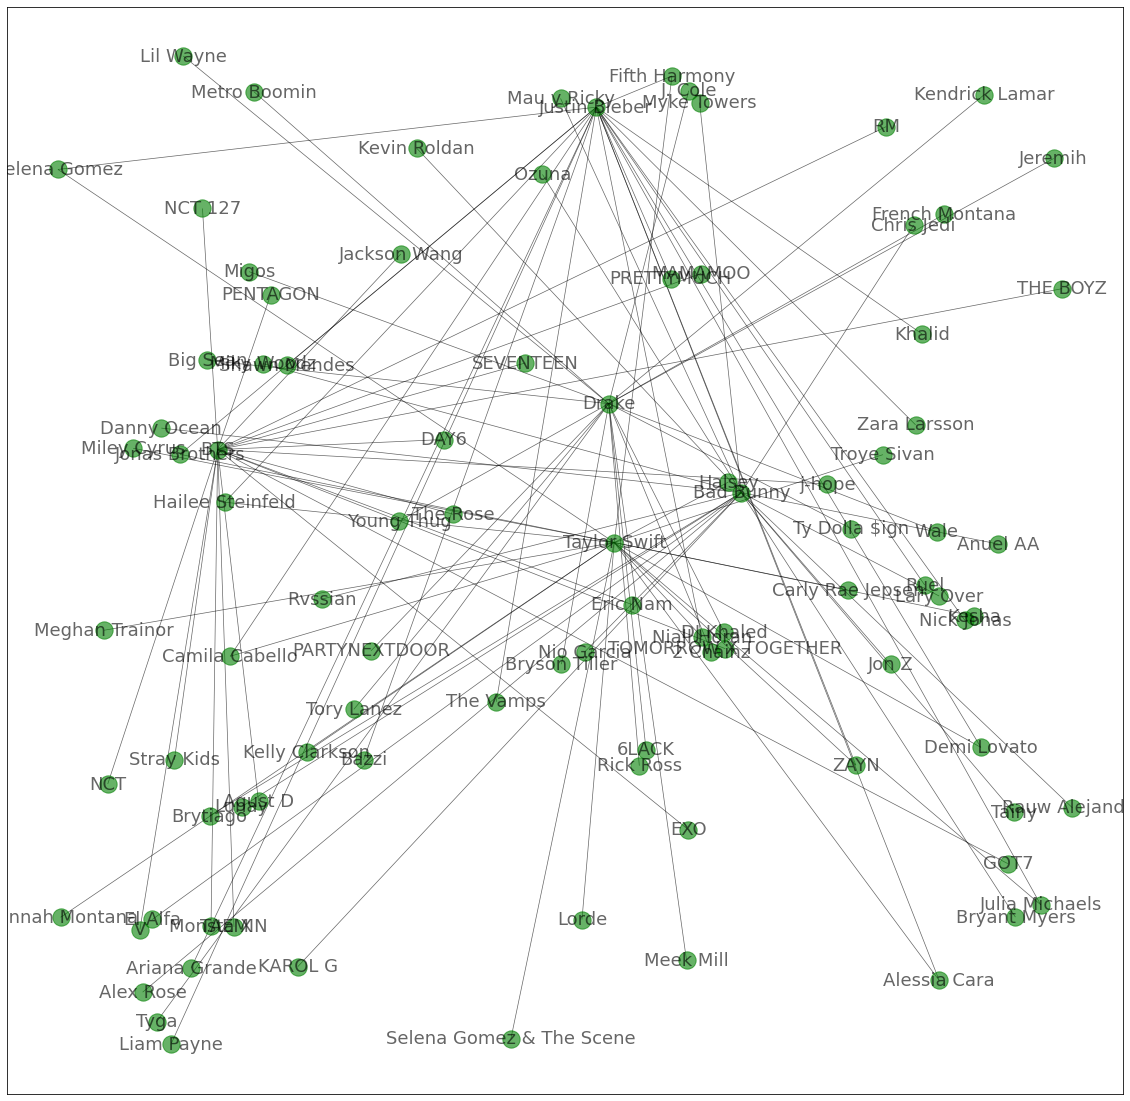

In [10]:
plt.figure(3,figsize=(20,20)) 
pos = nx.random_layout(G, seed=23)
nx.draw_networkx(G, font_size=18, node_color='green', with_labels=True,   pos = pos, alpha = 0.6, width = 0.7)

#### Looking for common neighbours

In [ ]:
node_list = G.nodes
source = []
target = []
common_neighbors = []
for u in node_list:
  for v in node_list:
    if u!=v:
      source.append(u)
      target.append(v)
      common_neighbors.append(len(list(nx.common_neighbors(G,u,v))))
df = pd.DataFrame(list(zip(source, target, common_neighbors)), 
               columns =['source', 'target', 'common_neighbors'])
df.head()

KeyboardInterrupt: ignored

### Graph features / parameters

In [11]:
nx.classes.function.density(G)

0.0005182370592264082

In [12]:
nx.average_clustering(G) 

0.25114680179398025

In [ ]:
nodes = G.nodes
degree_centrality = nx.degree_centrality(G)
for node in sorted(degree_centrality, key=degree_centrality.get):
  print(node) #[:4] needed for top 4 
  

Strick


AttributeError: ignored

### Link prediction algorithms

In [14]:
# 2. Jaccard coefficient
data = edge_list
jaccard = []

for i in range(len(data)):
  jaccard.append(list(nx.jaccard_coefficient(G, [(data['name'].iloc[i], data['artist_to'].iloc[i])]))[0][2])
data['jaccard_similarity'] = pd.DataFrame(jaccard)

data.head()

,name,artist_to,popularity,jaccard_similarity
0,Justin Bieber,ZAYN,100,0.428571
1,Justin Bieber,Shawn Mendes,100,0.483871
2,Justin Bieber,Camila Cabello,100,0.355556
3,Justin Bieber,Niall Horan,100,0.352941
4,Justin Bieber,Selena Gomez,100,0.324324


In [ ]:
print(list(nx.adamic_adar_index(G)))

In [ ]:
temp = pd.DataFrame({	
    'nodes': G.nodes,	
    'personalization': 0*len(G.nodes)	
})

In [ ]:
temp.head()

In [ ]:
temp.loc[temp.nodes == 1, 'personalization'] = 1
temp.loc[temp.nodes == 3, 'personalization'] = 1

In [ ]:
personalization = temp.set_index('nodes')['personalization'].to_dict()

In [ ]:
nx.pagerank(G, personalization=personalization)

In [ ]:
# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [ ]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

In [ ]:
len(all_unconnected_pairs)

In [ ]:

node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [ ]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

In [ ]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [ ]:
data['link'].value_counts()

In [ ]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
!pip install node2vec
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

In [ ]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [ ]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

In [ ]:
predictions = lr.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])

In [ ]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)